In [1]:
import warnings
from pathlib import Path
import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

warnings.filterwarnings("ignore")

CWD = Path().resolve()

DB_FILE = None
for p in [CWD] + list(CWD.parents):
    cand = p / "db" / "nflpa.duckdb"
    if cand.exists():
        DB_FILE = cand
        break
if DB_FILE is None:
    for p in [CWD] + list(CWD.parents):
        cand = p / "nflpa.duckdb"
        if cand.exists():
            DB_FILE = cand
            break
if DB_FILE is None:
    raise RuntimeError("Could not find nflpa.duckdb")

con = duckdb.connect(str(DB_FILE), read_only=False)

need = [
    "step21_frame",
    "step22_count_model_parameters",
    "step22_count_effect_translations",
    "step22_logit_effect_translations",
    "step22_league_level_scaling",
]
existing = set(con.execute("SHOW TABLES").df()["name"].astype(str).tolist())
missing = [t for t in need if t not in existing]
print("missing", missing)
if missing:
    raise RuntimeError("Missing required tables for the 10 graph notebook")

df = con.execute("SELECT * FROM step21_frame").df()
count_params = con.execute("SELECT * FROM step22_count_model_parameters").df()
count_eff = con.execute("SELECT * FROM step22_count_effect_translations").df()
logit_eff = con.execute("SELECT * FROM step22_logit_effect_translations").df()
league = con.execute("SELECT * FROM step22_league_level_scaling").df()

out_dir = Path("../outputs")
out_dir.mkdir(parents=True, exist_ok=True)

print("loaded", len(df), "team weeks")

missing []
loaded 5950 team weeks


In [2]:
SHOCK_COL = "shock_nonscore"
VOL_COL = "vol_nonscore_roll4_prior"
CUM_COL = "cum_shocks_nonscore_prior"
DEF_Y = "Inj_Def_Next_w"
OFF_Y = "Inj_Off_Next_w"

for c in [SHOCK_COL, VOL_COL, CUM_COL, DEF_Y, OFF_Y, "season", "week"]:
    if c not in df.columns:
        raise RuntimeError(f"Missing {c} in step21_frame")

df["season"] = df["season"].astype(int)
df["week"] = df["week"].astype(int)

In [3]:
pdf_path = out_dir / "step22_report_figures_10plots.pdf"
pp = PdfPages(pdf_path)

def _save_fig():
    pp.savefig(plt.gcf(), bbox_inches="tight")
    plt.close()

Text(0, 0.5, 'count')

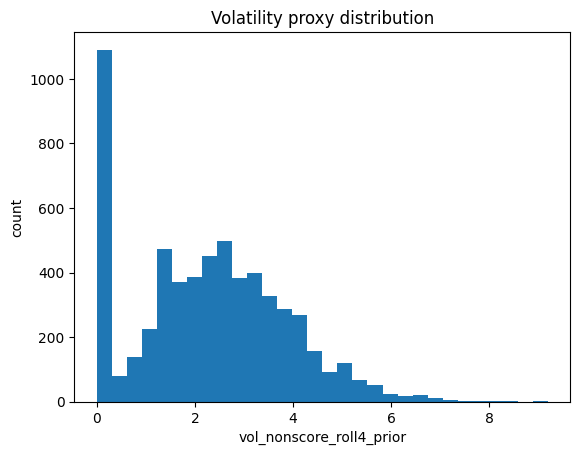

In [14]:
plt.figure()
plt.hist(df[VOL_COL].astype(float).dropna().values, bins=30)
plt.title("Volatility proxy distribution")
plt.xlabel(VOL_COL)
plt.ylabel("count")

Text(0, 0.5, 'mean shock indicator')

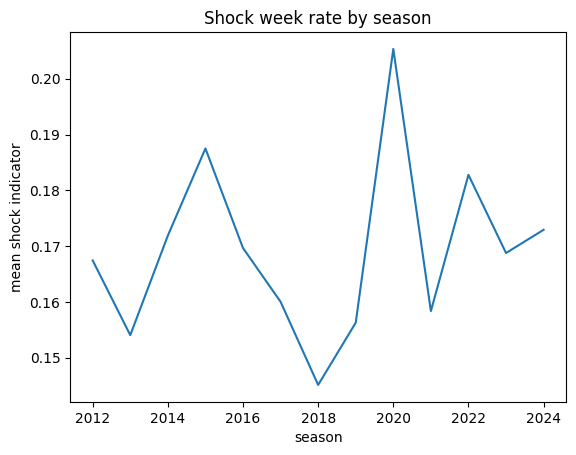

In [15]:
shock_rate = df.groupby("season", as_index=False)[SHOCK_COL].mean()

plt.figure()
plt.plot(shock_rate["season"].astype(int), shock_rate[SHOCK_COL].astype(float))
plt.title("Shock week rate by season")
plt.xlabel("season")
plt.ylabel("mean shock indicator")

Text(0, 0.5, 'mean Inj off next week')

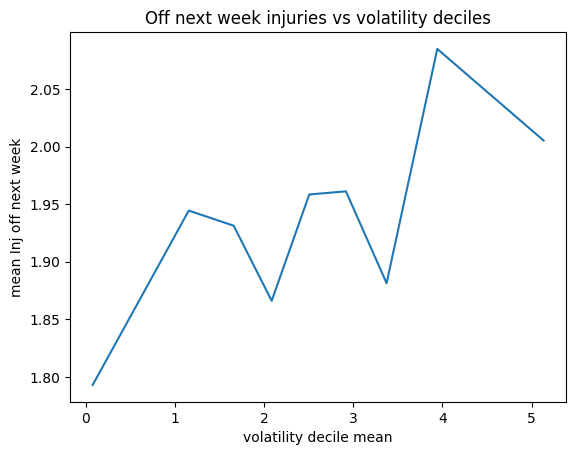

In [16]:
tmp = df[[VOL_COL, OFF_Y]].copy()
tmp[VOL_COL] = tmp[VOL_COL].astype(float)
tmp[OFF_Y] = tmp[OFF_Y].astype(float)

tmp["vol_bin"] = pd.qcut(tmp[VOL_COL], q=10, duplicates="drop")
b = tmp.groupby("vol_bin", as_index=False).agg(vol_mid=(VOL_COL, "mean"), y_mean=(OFF_Y, "mean"))

plt.figure()
plt.plot(b["vol_mid"].astype(float), b["y_mean"].astype(float))
plt.title("Off next week injuries vs volatility deciles")
plt.xlabel("volatility decile mean")
plt.ylabel("mean Inj off next week")

Text(0, 0.5, 'mean Inj def next week')

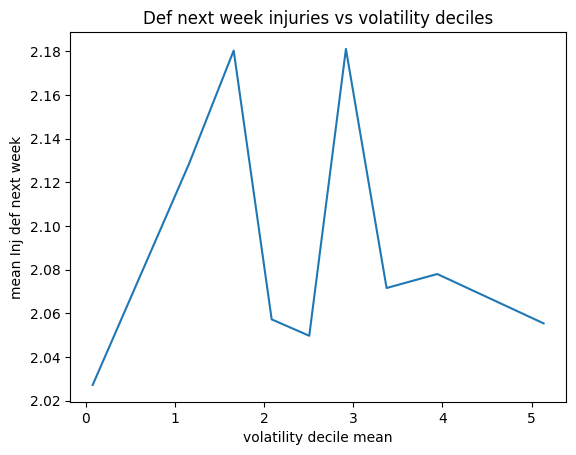

In [17]:
tmp = df[[VOL_COL, DEF_Y]].copy()
tmp[VOL_COL] = tmp[VOL_COL].astype(float)
tmp[DEF_Y] = tmp[DEF_Y].astype(float)

tmp["vol_bin"] = pd.qcut(tmp[VOL_COL], q=10, duplicates="drop")
b = tmp.groupby("vol_bin", as_index=False).agg(vol_mid=(VOL_COL, "mean"), y_mean=(DEF_Y, "mean"))

plt.figure()
plt.plot(b["vol_mid"].astype(float), b["y_mean"].astype(float))
plt.title("Def next week injuries vs volatility deciles")
plt.xlabel("volatility decile mean")
plt.ylabel("mean Inj def next week")

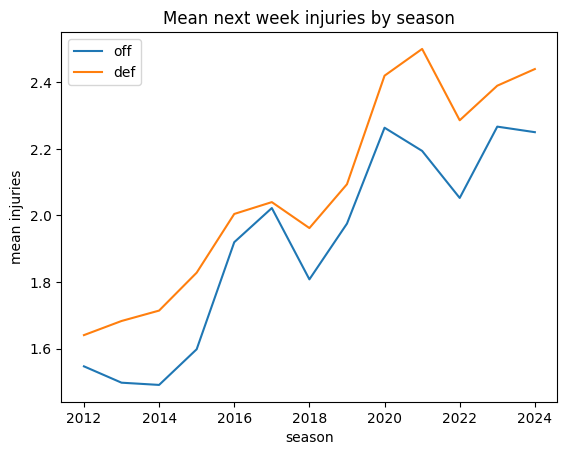

In [19]:
tmp = df.groupby("season", as_index=False).agg(
    off_mean=(OFF_Y, "mean"),
    def_mean=(DEF_Y, "mean"),
)

plt.figure()
plt.plot(tmp["season"].astype(int), tmp["off_mean"].astype(float), label="off")
plt.plot(tmp["season"].astype(int), tmp["def_mean"].astype(float), label="def")
plt.title("Mean next week injuries by season")
plt.xlabel("season")
plt.ylabel("mean injuries")
plt.legend()

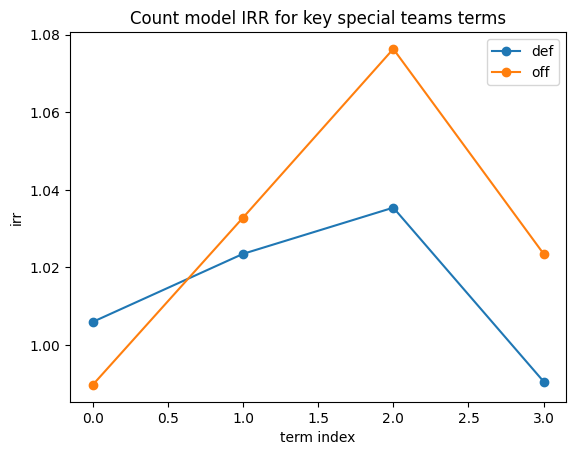

In [20]:
key_terms = [SHOCK_COL, "shock_x_blowout", VOL_COL, CUM_COL]
cp = count_params[count_params["term"].astype(str).isin(key_terms)].copy()

if "irr" not in cp.columns:
    cp["irr"] = np.exp(cp["beta"].astype(float))

plt.figure()
for side in ["def", "off"]:
    s = cp[cp["side"].astype(str) == side].copy()
    s = s.sort_values("term")
    plt.plot(np.arange(len(s)), s["irr"].astype(float), label=side, marker="o")
plt.title("Count model IRR for key special teams terms")
plt.xlabel("term index")
plt.ylabel("irr")
plt.legend()

([<matplotlib.axis.XTick at 0x13141c6e0>,
 [Text(0, 0, 'def_shock_0_to_1'),
  Text(1, 0, 'def_vol_25_to_75'),
  Text(2, 0, 'def_cum_plus_1'),
  Text(3, 0, 'off_shock_0_to_1'),
  Text(4, 0, 'off_vol_25_to_75'),
  Text(5, 0, 'off_cum_plus_1')])

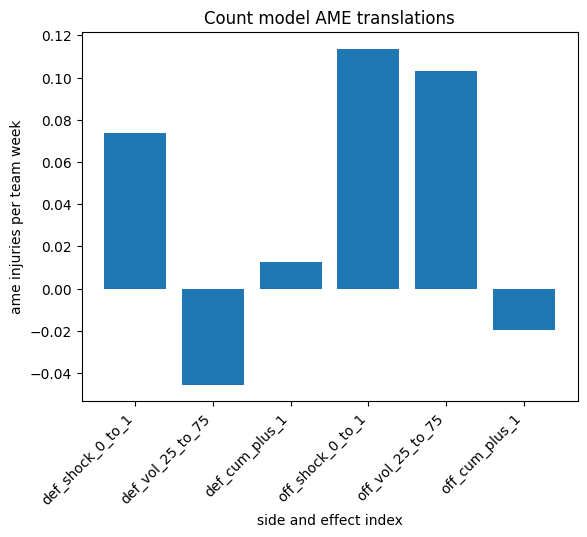

In [21]:
ce = count_eff[count_eff["effect"].astype(str).isin(["shock_0_to_1", "vol_25_to_75", "cum_plus_1"])].copy()

labels = (ce["side"].astype(str) + "_" + ce["effect"].astype(str)).tolist()
vals = ce["ame"].astype(float).tolist()

plt.figure()
plt.bar(np.arange(len(vals)), vals)
plt.title("Count model AME translations")
plt.xlabel("side and effect index")
plt.ylabel("ame injuries per team week")
plt.xticks(np.arange(len(vals)), labels, rotation=45, ha="right")

([<matplotlib.axis.XTick at 0x131115520>,
 [Text(0, 0, 'def_shock_0_to_1'),
  Text(1, 0, 'def_vol_25_to_75'),
  Text(2, 0, 'def_cum_plus_1'),
  Text(3, 0, 'off_shock_0_to_1'),
  Text(4, 0, 'off_vol_25_to_75'),
  Text(5, 0, 'off_cum_plus_1')])

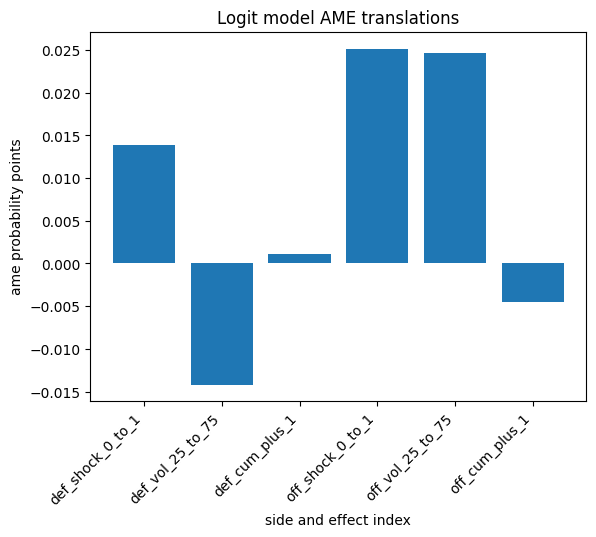

In [22]:
le = logit_eff[logit_eff["effect"].astype(str).isin(["shock_0_to_1", "vol_25_to_75", "cum_plus_1"])].copy()

labels = (le["side"].astype(str) + "_" + le["effect"].astype(str)).tolist()
vals = le["ame_prob"].astype(float).tolist()

plt.figure()
plt.bar(np.arange(len(vals)), vals)
plt.title("Logit model AME translations")
plt.xlabel("side and effect index")
plt.ylabel("ame probability points")
plt.xticks(np.arange(len(vals)), labels, rotation=45, ha="right")

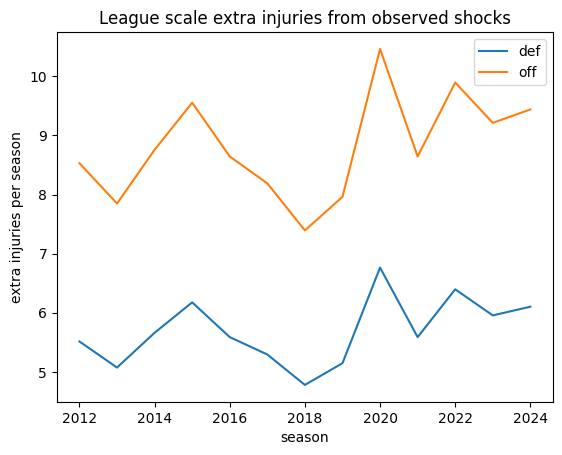

In [23]:
plt.figure()
plt.plot(league["season"].astype(int), league["extra_def_inj_from_shocks_observed"].astype(float), label="def")
plt.plot(league["season"].astype(int), league["extra_off_inj_from_shocks_observed"].astype(float), label="off")
plt.title("League scale extra injuries from observed shocks")
plt.xlabel("season")
plt.ylabel("extra injuries per season")
plt.legend()

In [13]:
pp.close()
print("wrote", str(pdf_path))

wrote ../outputs/step22_report_figures_10plots.pdf
